In [2]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint
import configparser, re, os, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus
from sklearn.preprocessing import LabelBinarizer
import pyLDAvis
import pyLDAvis.gensim_models
import tweepy as tw
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.linear_model import LogisticRegression
import string
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)

In [4]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
from matplotlib import font_manager
font_set = {f.name for f in font_manager.fontManager.ttflist}
# matplotlib.rcParams['font.family'] = ['Noto Sans Mono CJK TC', 'sans-serif']
plt.rcParams["font.sans-serif"] = ["Noto Sans CJK JP"]
# plt.plot((1, 2, 3), (4, 3, -1))
# plt.title("聲量圖")

# 文件分類 #

In [11]:
def cut_sent(para):
    para = re.sub('([。！？\?])([^”’])', r"\1\n\2", para)  # 斷句符號
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略號
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略號
    para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)
    para = para.rstrip()  # 去掉句尾多餘的空白
    para = re.split("\r|[\n]+",para) # 找到一個或多個\n都可以斷句
    para_list = list(filter(None, para))
    return para_list 

<>:2: DeprecationWarning: invalid escape sequence '\?'
<>:3: DeprecationWarning: invalid escape sequence '\.'
<>:5: DeprecationWarning: invalid escape sequence '\?'
<>:2: DeprecationWarning: invalid escape sequence '\?'
<>:3: DeprecationWarning: invalid escape sequence '\.'
<>:5: DeprecationWarning: invalid escape sequence '\?'
C:\Users\user\AppData\Local\Temp\ipykernel_14356\1390183601.py:2: DeprecationWarning: invalid escape sequence '\?'
  para = re.sub('([。！？\?])([^”’])', r"\1\n\2", para)  # 斷句符號
C:\Users\user\AppData\Local\Temp\ipykernel_14356\1390183601.py:3: DeprecationWarning: invalid escape sequence '\.'
  para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略號
C:\Users\user\AppData\Local\Temp\ipykernel_14356\1390183601.py:5: DeprecationWarning: invalid escape sequence '\?'
  para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)


In [13]:
udn = pd.read_csv("raw_data/sna2023s_5_ff8e210cdd_4.csv")  # 匯資料
udn.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/movie/M.1329932440.A.CA...,Fw:[情報]看《復仇者聯盟》之前的必備懶人包(微雷),2012-02-22 17:34:38,luciferpku,movie,（微雷提醒）\n提醒你，這是一篇關於《鋼鐵人》、《鋼鐵人２》、\n《無敵浩克》、《雷神索爾》...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""HouseOfSleep...",NaN,2018-04-27 17:02:21,ptt
1,2,https://www.ptt.cc/bbs/movie/M.1364375647.A.91...,[新聞]《金鋼狼》搞3P葛妮絲變鋼鐵辣椒,2013-03-27 09:08:04,Lr,movie,新聞網址：\nhttp://ppt.cc/WCM8\n中國時報【影視組╱綜合報導】\n\n《...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ManUtd5566"",...",NaN,2018-04-27 17:02:56,ptt
2,3,https://www.ptt.cc/bbs/movie/M.1365409989.A.FD...,"[贈票]集氣力挺鋼鐵人,送首映電影票",2013-04-08 08:27:06,phibi,movie,親愛的網友您好\n想要搶先看【鋼鐵人3】嗎?\n只要參加以下活動與外推FB活動訊息並且留下您...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""crazylovewow...",NaN,2018-04-27 17:03:19,ptt


In [15]:
# 篩選需要的欄位
udn['content'] = udn['artTitle'] + udn['artContent']
udn = udn.dropna() #去掉空白欄位
data = udn[['content','artUrl']] #文章內容 文章連結data.head(3)

# 把句子切開
data['sentence'] = data.apply(lambda row : cut_sent(row['content']), axis=1) #把句子切開
data = data[['sentence','artUrl']].explode("sentence")
data['document'] = range(0, len(data))
data.head(3)

C:\Users\user\AppData\Local\Temp\ipykernel_14356\450201891.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'] = data.apply(lambda row : cut_sent(row['content']), axis=1) #把句子切開


,sentence,artUrl,document
118,[好雷]美國隊長2-想做還是做得到的，漫威不提是sony拍的新蜘蛛人，,https://www.ptt.cc/bbs/movie/M.1395904860.A.06...,0
118,就最近的鋼鐵人3，雷神索爾2，美國隊長2，,https://www.ptt.cc/bbs/movie/M.1395904860.A.06...,1
118,可以感覺漫威的劇情質量有明顯提升，,https://www.ptt.cc/bbs/movie/M.1395904860.A.06...,2


In [16]:
def load_stop_words(path):
    with open(path,encoding='utf-8') as f:
        stopWords = [line.strip() for line in f.readlines()]
    return stopWords

def get_tokens(sent,user_dict,stop_dict):
    
    # 去除noise 斷詞
    jieba.load_userdict(user_dict) # 客製化字典    
    sent = re.sub('[^\u4e00-\u9fa5]+', '', sent) # 過濾標點符號、英文、數字，只留中文
    words = list(jieba.cut(sent)) # 斷詞

    #去除停用字
    stopWords = load_stop_words(stop_dict)    
    words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
    return " ".join(words)

In [17]:
# 這裡會跑比較久
stop_path = 'dict/stopwords.txt'
user_path = "dict/user_dict.txt"

# 把句子切開，待會丟DTM
data['clean_txt'] = data.apply(lambda row : get_tokens(row['sentence'],user_path,stop_path), axis=1) 
data.head(5)

,sentence,artUrl,document,clean_txt
118,[好雷]美國隊長2-想做還是做得到的，漫威不提是sony拍的新蜘蛛人，,https://www.ptt.cc/bbs/movie/M.1395904860.A.06...,0,好雷 美國隊長 做得到 漫威 不提 蜘蛛人
118,就最近的鋼鐵人3，雷神索爾2，美國隊長2，,https://www.ptt.cc/bbs/movie/M.1395904860.A.06...,1,最近 鋼鐵人 雷神索爾 美國隊長
118,可以感覺漫威的劇情質量有明顯提升，,https://www.ptt.cc/bbs/movie/M.1395904860.A.06...,2,感覺 漫威 劇情 質量 明顯 提升
118,期待復仇者聯盟2也能持續如此，不要再只是一場大堆頭的同學會。,https://www.ptt.cc/bbs/movie/M.1395904860.A.06...,3,期待 復仇者聯盟 持續 一場 大堆頭 同學會
118,美國隊長2的前面很棒，拋開神盾局的漫畫元素，,https://www.ptt.cc/bbs/movie/M.1395904860.A.06...,4,美國隊長 前面 很棒 拋開 神盾局 漫畫 元素


In [18]:
# 把字詞斷開，待會情緒分析
token_df = data[['document','clean_txt']]
token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list
token_df = token_df[['document','word']].explode("word").reset_index(drop=True) # 把切開的list展開
token_df.head(5)

C:\Users\user\AppData\Local\Temp\ipykernel_14356\572871011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list


,document,word
0,0,好雷
1,0,美國隊長
2,0,做得到
3,0,漫威
4,0,不提


<b>算出情緒分數，將正負面文章分類</b>

In [19]:
# # 參考 week4 code
# def load_senti():
#     filepath = ['negative','positive']
#     d_liwc = []
#     for file in filepath:
#         filename = f"./dict/liwc/{file}.txt"
#         with open(filename, 'r', encoding='UTF-8-sig') as f:
#             d_liwc.append([f.read().split("\n"),file])
#     df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)    
#     df_liwc['word'] = df_liwc['word'].str.replace('"\n','')
    
#     return df_liwc

filepath = ['negative','positive']
d_liwc = []
for file in filepath:
    filename = f"./dict/liwc/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split(","),file])
        
data_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)
data_liwc

,word,sentiments
0,一無所有,negative
1,七竅生煙,negative
2,上當,negative
3,下流,negative
4,下等,negative
...,...,...
1706,魅力,positive
1707,鮮明,positive
1708,鮮美,positive
1709,鼓勵,positive


In [22]:
# 新增的負面詞
neg_added = ["好雷"] 
for w in neg_added:
    data_liwc.loc[-1] = [w, "negative"]
    data_liwc.index = data_liwc.index + 1
    data_liwc = data_liwc.sort_index()

In [23]:
# 統計文章情緒
senti_df = pd.merge(token_df, data_liwc, on=['word'],how='inner') # token和情緒字典做merge
senti_count = senti_df.groupby(['document','sentiments'],as_index=False).size() # 算出每篇文章的情緒
senti_count = senti_count.pivot(index='document',columns='sentiments',values='size').fillna(0) # 把資料展開，缺值補零
senti_count = senti_count.reset_index().rename_axis(None, axis=1) # 把兩個level變成一層level

# 幫文章加上標籤
senti_count['label'] = np.where(senti_count['positive'] >= senti_count['negative'], 'pos','neg')
senti_count.head(5)

,document,negative,positive,label
0,0,1.0,0.0,neg
1,4,0.0,1.0,pos
2,6,1.0,1.0,pos
3,8,0.0,1.0,pos
4,11,1.0,0.0,neg


In [24]:
# token和情緒字典做merge
data_senti = pd.merge(data, senti_count[['document','label']], on=['document'],how='left').fillna('neu') 
data_senti.head(5)

,sentence,artUrl,document,clean_txt,label
0,[好雷]美國隊長2-想做還是做得到的，漫威不提是sony拍的新蜘蛛人，,https://www.ptt.cc/bbs/movie/M.1395904860.A.06...,0,好雷 美國隊長 做得到 漫威 不提 蜘蛛人,neg
1,就最近的鋼鐵人3，雷神索爾2，美國隊長2，,https://www.ptt.cc/bbs/movie/M.1395904860.A.06...,1,最近 鋼鐵人 雷神索爾 美國隊長,neu
2,可以感覺漫威的劇情質量有明顯提升，,https://www.ptt.cc/bbs/movie/M.1395904860.A.06...,2,感覺 漫威 劇情 質量 明顯 提升,neu
3,期待復仇者聯盟2也能持續如此，不要再只是一場大堆頭的同學會。,https://www.ptt.cc/bbs/movie/M.1395904860.A.06...,3,期待 復仇者聯盟 持續 一場 大堆頭 同學會,neu
4,美國隊長2的前面很棒，拋開神盾局的漫畫元素，,https://www.ptt.cc/bbs/movie/M.1395904860.A.06...,4,美國隊長 前面 很棒 拋開 神盾局 漫畫 元素,pos


In [25]:
# 算兩種資料框的字頻
word_count = (pd.merge(token_df, data_senti[['document','label']], 
                  on=['document'],how='left') 
                 .groupby(['label','word'], as_index=False).size()
                 .sort_values(by=['label','size'], ascending=False))
word_count.head(5)

,label,word,size
161201,pos,電影,11889
152121,pos,英雄,11647
143276,pos,漫威,7750
118981,pos,作品,3848
154141,pos,角色,3758


In [26]:
# 選出兩類文章最高的20個字
top_n = 20
book1 = word_count[word_count["label"]=="neg"].head(top_n).sort_values(by=['size']) # 負面情緒 
book2 = word_count[word_count["label"]=="pos"].head(top_n).sort_values(by=['size']) # 正面情緒
book1.head(5)

,label,word,size
13296,neg,復仇者聯盟,646
17328,neg,新聞,651
1677,neg,主角,655
24232,neg,看到,677
16903,neg,故事,678


C:\Users\user\AppData\Local\Temp\ipykernel_14356\2666126548.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


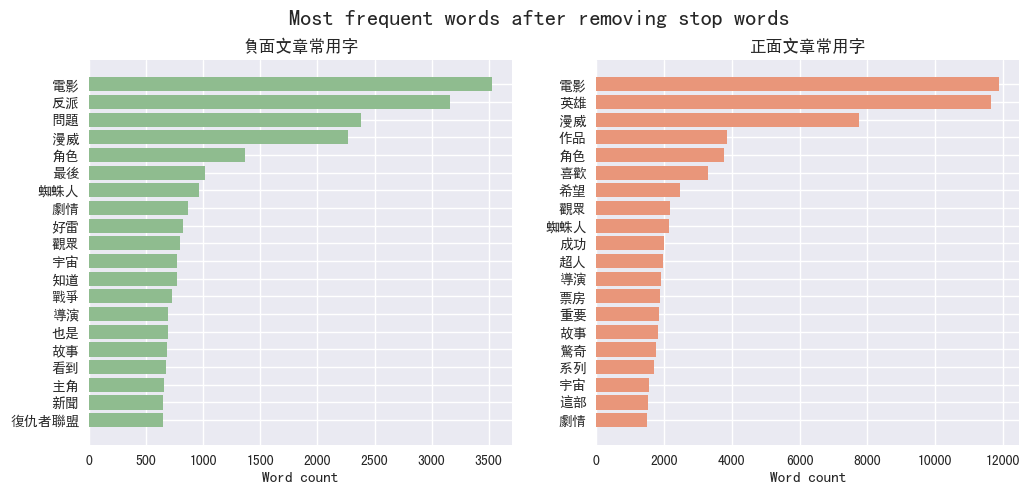

In [27]:
from matplotlib.font_manager import FontProperties

plt.figure(figsize=(12,5))   
plt.style.use('seaborn') 
plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文

plt.subplot(121)
plt.title('負面文章常用字')
plt.xlabel('Word count')
plt.barh(book1['word'],book1['size'],color="darkseagreen")

plt.subplot(122)
plt.title('正面文章常用字')
plt.xlabel('Word count')
plt.barh(book2['word'],book2['size'],color="darksalmon")

# 最上面的標題
plt.suptitle('Most frequent words after removing stop words', fontsize=16)
plt.show()

### 切分資料集 ###

In [38]:
# 資料量太大，取一半來訓練
data = data_senti
aa, data_half = train_test_split(data,test_size=0.5,random_state=777)

In [39]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['label'].value_counts(normalize=True) * 100}"
)
print(f"\ndata half percentage :\n{data_half.value_counts(normalize=True) * 100}")

raw data percentage :
label
neu    69.196597
pos    20.202794
neg    10.600609
Name: proportion, dtype: float64

data half percentage :
sentence                                      artUrl                                                document  clean_txt                            label
                                              https://www.ptt.cc/bbs/movie/M.1630572228.A.0AA.html  277002                                         neu      0.000555
根據訴訟，在該系列成功之後，漫威主編C.B.塞布林斯基（C.B. Cebulski）曾邀  https://www.ptt.cc/bbs/movie/M.1620403284.A.03D.html  260191    訴訟 系列 成功 之後 漫威 主編 布林 斯基              pos      0.000555
根據英國《BBC》報導，漫威和大陸網路公司「網易」聯手打造的陸版超級英雄已經展開連     https://www.ptt.cc/bbs/movie/M.1526446415.A.443.html  128903    英國 報導 漫威 大陸 網路 公司 網易 聯手 打造 陸版 英雄 展開  pos      0.000555
根據英國《太陽報》的報導，《永恆族》日前在西班牙加那                    https://www.ptt.cc/bbs/movie/M.1572954598.A.12A.html  215538    英國 太陽報 報導 永恆族 日前 西班牙                 neu      0.000555
根據英國「每日郵報」（Daily Mail），「美國隊長3」演出陣容還包括「鋼鐵人」小勞  https

In [40]:
X = data_half["clean_txt"]
y = data_half["label"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

202018               討論 還想 看到 大牌 影星 加入 漫威宇宙
7446                      去年 天大 佈局 再度 贏得 提名
78071                           最後 說說 兩個 主角
211123    很難 想像 小丑 那種 世界觀 出現 穿著 蝙蝠 打擊 犯罪 人物
144356                             眷屬 是一 看點
Name: clean_txt, dtype: object
202018    neu
7446      pos
78071     neu
211123    neg
144356    neu
Name: label, dtype: object


In [42]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data_half['label'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
label
neu    69.229360
pos    20.153373
neg    10.617267
Name: proportion, dtype: float64

train percentage :
label
neu    69.203859
pos    20.147868
neg    10.648273
Name: proportion, dtype: float64

test percentage :
label
neu    69.288861
pos    20.166216
neg    10.544923
Name: proportion, dtype: float64


In [43]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [44]:
X_train.head()

202018               討論 還想 看到 大牌 影星 加入 漫威宇宙
7446                      去年 天大 佈局 再度 贏得 提名
78071                           最後 說說 兩個 主角
211123    很難 想像 小丑 那種 世界觀 出現 穿著 蝙蝠 打擊 犯罪 人物
144356                             眷屬 是一 看點
Name: clean_txt, dtype: object

In [45]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<126058x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 340696 stored elements in Compressed Sparse Row format>

In [46]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [47]:
# 可用 `fit_transform()` 一次完成
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names_out()[:10])

['一下' '一位' '一句' '一堆' '一場' '一年' '一次' '一段' '一直' '一種']


In [48]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['一下']

{'討論': 813, '看到': 676, '加入': 160, '漫威宇宙': 607, '去年': 181, '再度': 134, '提名': 467, '最後': 530, '兩個': 126, '主角': 43, '很難': 377, '想像': 401, '小丑': 312, '那種': 906, '世界觀': 33, '出現': 142, '人物': 71, '是一': 508, '美國': 750, '觀眾': 805, '熟悉': 616, '漫畫': 609, '現場': 642, '透露': 874, '電影': 957, '漫威': 606, '好萊塢': 278, '蟻人': 789, '男星': 653, '分享': 143, '世界': 32, '一點': 14, '事情': 62, '行為': 792, '地方': 235, '尷尬': 324, '衝突': 793, '閃電俠': 933, '隊長': 946, '鷹眼': 994, '認為': 829, '對話': 309, '這部': 883, '星際異攻隊': 507, '思考': 391, '模式': 561, '英雄': 775, '商業': 215, '爽片': 620, '記憶': 815, '片段': 625, '之間': 49, '深度': 597, '超過': 858, '動畫': 164, '製作': 799, '人員': 68, '特色': 632, '名字': 209, '奇怪': 260, '之外': 47, '奇異博士': 261, '導致': 311, '完全': 290, '憤怒': 417, '這也': 877, '真正': 685, '未來': 549, '都會': 912, '黑寡婦': 997, '合作': 203, '角色': 808, '之後': 48, '一堆': 3, '喜劇': 218, '政治': 479, '正確': 570, '犧牲': 633, '新聞': 491, '克里斯伊凡': 115, '美國隊長': 751, '系列': 720, '永遠': 583, '令人': 82, '失望': 258, '大戰': 252, '金剛': 926, '女孩': 268, '真實': 683, '導演': 310, '演員': 

0

In [49]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(126058, 1000)
(54026, 1000)


In [50]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [51]:
clf.classes_

array(['neg', 'neu', 'pos'], dtype=object)

In [52]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['pos' 'neu' 'neu' 'neu' 'neu' 'neu' 'neu' 'neu' 'neu' 'neu']


In [53]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(54026, 3)


array([0.00474318, 0.0069398 , 0.98831702])

In [54]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         neg       0.89      0.47      0.62      5697
         neu       0.87      1.00      0.93     37434
         pos       0.97      0.73      0.83     10895

    accuracy                           0.89     54026
   macro avg       0.91      0.73      0.79     54026
weighted avg       0.89      0.89      0.88     54026



In [55]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 2683,  2828,   186],
       [   94, 37252,    88],
       [  243,  2662,  7990]], dtype=int64)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'neg'), Text(0, 1.5, 'neu'), Text(0, 2.5, 'pos')])

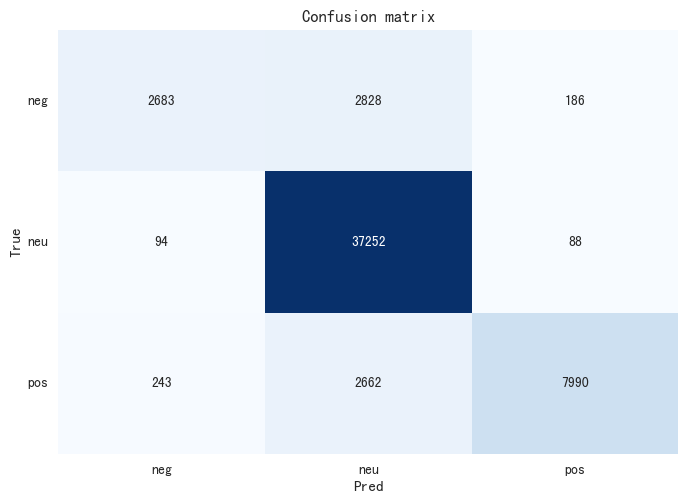

In [56]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

In [57]:
# one-hot encoding
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
print(y_onehot_test.shape)  # (n_samples, n_classes)
y_onehot_test[0,:]

(54026, 3)


array([0, 0, 1])

In [58]:
y_test.iloc[0]

'pos'

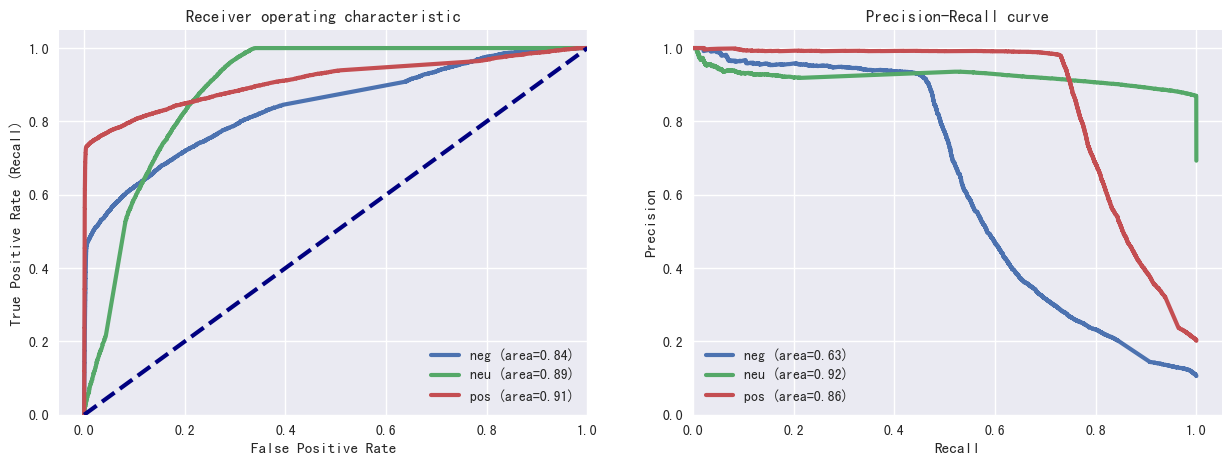

In [59]:
# plot ROC curve and precision-recall curve
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
    ax[0].plot(
        fpr, tpr, lw=3, label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr))
    )
ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
ax[0].set(
    xlim=[-0.05, 1.0],
    ylim=[0.0, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate (Recall)",
    title="Receiver operating characteristic",
)
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
        y_onehot_test[:, i], y_pred_proba[:, i]
    )
    ax[1].plot(
        recall,
        precision,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
    )
ax[1].set(
    xlim=[0.0, 1.05],
    ylim=[0.0, 1.05],
    xlabel="Recall",
    ylabel="Precision",
    title="Precision-Recall curve",
)
ax[1].legend(loc="best")
ax[1].grid(True)

plt.show()

改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [60]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [61]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         neg       0.91      0.46      0.61      5697
         neu       0.87      1.00      0.93     37434
         pos       0.98      0.73      0.84     10895

    accuracy                           0.89     54026
   macro avg       0.92      0.73      0.79     54026
weighted avg       0.90      0.89      0.88     54026



## CV  ##

In [62]:
clf = LogisticRegression()
vec_train = CountVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([1.39989734, 1.41612458, 1.40499806, 1.41728473, 1.38223815]),
 'score_time': array([0.43943167, 0.42988634, 0.43622351, 0.43065572, 0.42929482]),
 'test_f1_macro': array([0.78849432, 0.79936648, 0.80141143, 0.79950671, 0.79375466]),
 'test_precision_macro': array([0.90526405, 0.90737389, 0.91268568, 0.91014761, 0.90850218]),
 'test_recall_macro': array([0.72866975, 0.74145571, 0.74206926, 0.74023381, 0.73453227])}


In [63]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

              precision    recall  f1-score   support

         neg       0.89      0.48      0.62     13423
         neu       0.87      0.99      0.93     87237
         pos       0.97      0.74      0.84     25398

    accuracy                           0.89    126058
   macro avg       0.91      0.74      0.80    126058
weighted avg       0.89      0.89      0.88    126058



C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

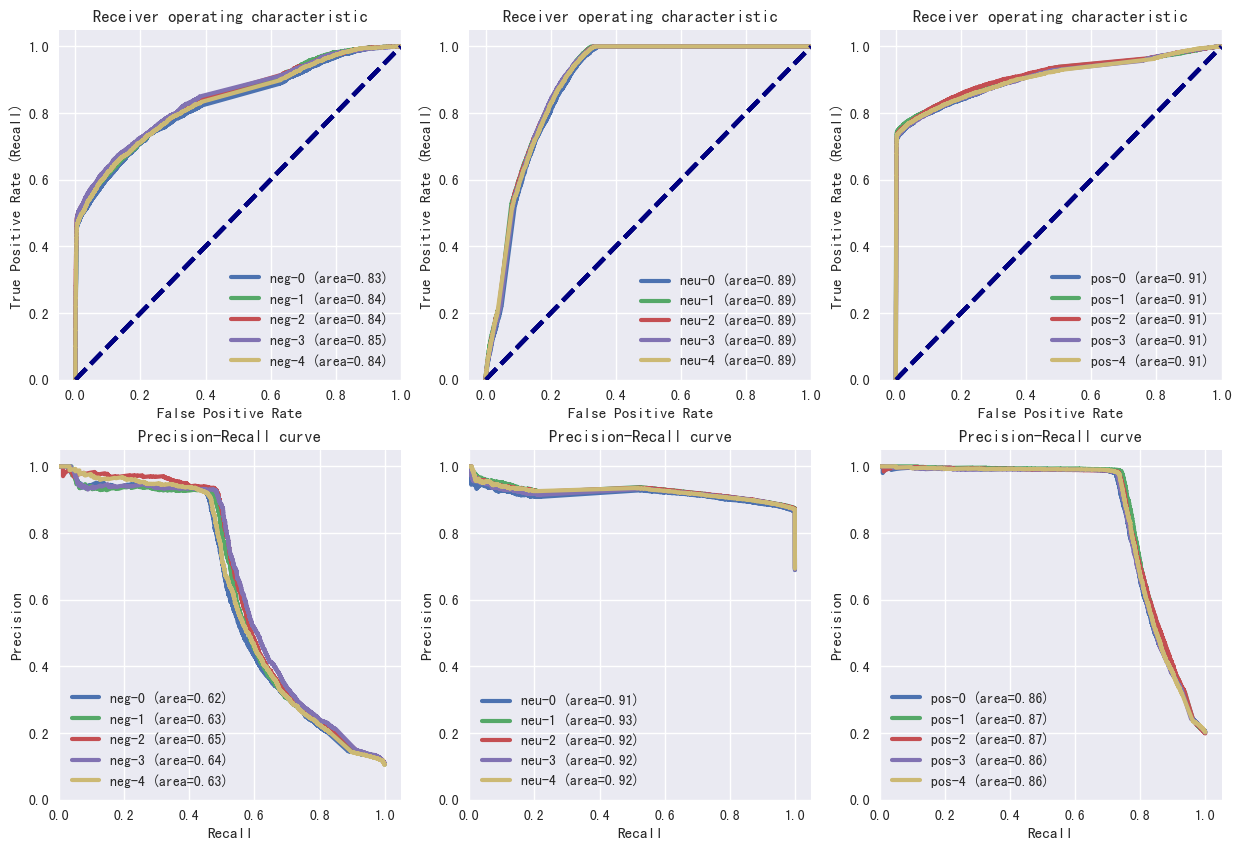

In [64]:
## 將三個類別的 ROC curve 分別畫出來，並在同一張圖上比較不同 fold 的結果
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
kf = KFold(n_splits=5)
classes = scores['estimator'][0].classes_

for k, (train, test) in enumerate(kf.split(vec_train, y_train)):
    clf.fit(vec_train[train,:], y_train.iloc[train])
    y_pred = clf.predict(vec_train[test,:])    
    y_test = y_train.iloc[test]
    y_pred_proba = clf.predict_proba(vec_train[test,:])
    y_onehot_test = label_binarizer.transform(y_test)        
    

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
        ax[0,i].plot(
            fpr,
            tpr,
            lw=3,
            label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
        )
        ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
        ax[0,i].set(
            xlim=[-0.05, 1.0],
            ylim=[0.0, 1.05],
            xlabel="False Positive Rate",
            ylabel="True Positive Rate (Recall)",
            title="Receiver operating characteristic",
        )
        ax[0,i].legend(loc="best")
        ax[0,i].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(
            y_onehot_test[:, i], y_pred_proba[:, i]
        )
        ax[1,i].plot(
            recall,
            precision,
            lw=3,
            label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
        )
        ax[1,i].set(
            xlim=[0.0, 1.05],
            ylim=[0.0, 1.05],
            xlabel="Recall",
            ylabel="Precision",
            title="Precision-Recall curve",
        )
        ax[1,i].legend(loc="best")
        ax[1,i].grid(True)

plt.show()

## 4. 比較不同模型效果

In [65]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)


    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    kf = KFold(n_splits=5)
    
    for k, (train, test) in enumerate(kf.split(vec_X, y)):
        clf.fit(vec_X[train,:], y.iloc[train])
        y_pred = clf.predict(vec_X[test,:])    
        y_test = y.iloc[test]
        y_pred_proba = clf.predict_proba(vec_X[test,:])
        y_onehot_test = label_binarizer.transform(y_test)        
        
    
        ## Plot roc
        for i in range(len(classes)):
            fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
            ax[0,i].plot(
                fpr,
                tpr,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
            )
            ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
            ax[0,i].set(
                xlim=[-0.05, 1.0],
                ylim=[0.0, 1.05],
                xlabel="False Positive Rate",
                ylabel="True Positive Rate (Recall)",
                title="Receiver operating characteristic",
            )
            ax[0,i].legend(loc="best")
            ax[0,i].grid(True)

        ## Plot precision-recall curve
        for i in range(len(classes)):
            precision, recall, thresholds = precision_recall_curve(
                y_onehot_test[:, i], y_pred_proba[:, i]
            )
            ax[1,i].plot(
                recall,
                precision,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
            )
            ax[1,i].set(
                xlim=[0.0, 1.05],
                ylim=[0.0, 1.05],
                xlabel="Recall",
                ylabel="Precision",
                title="Precision-Recall curve",
            )
            ax[1,i].legend(loc="best")
            ax[1,i].grid(True)

    plt.show()

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

now training: clf_logistic


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

              precision    recall  f1-score   support

         neg       0.89      0.48      0.62     13423
         neu       0.87      0.99      0.93     87237
         pos       0.97      0.74      0.84     25398

    accuracy                           0.89    126058
   macro avg       0.91      0.74      0.80    126058
weighted avg       0.89      0.89      0.88    126058



C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

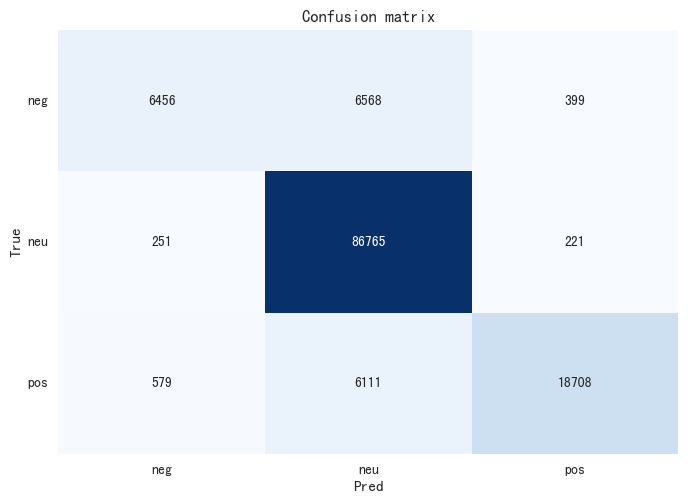

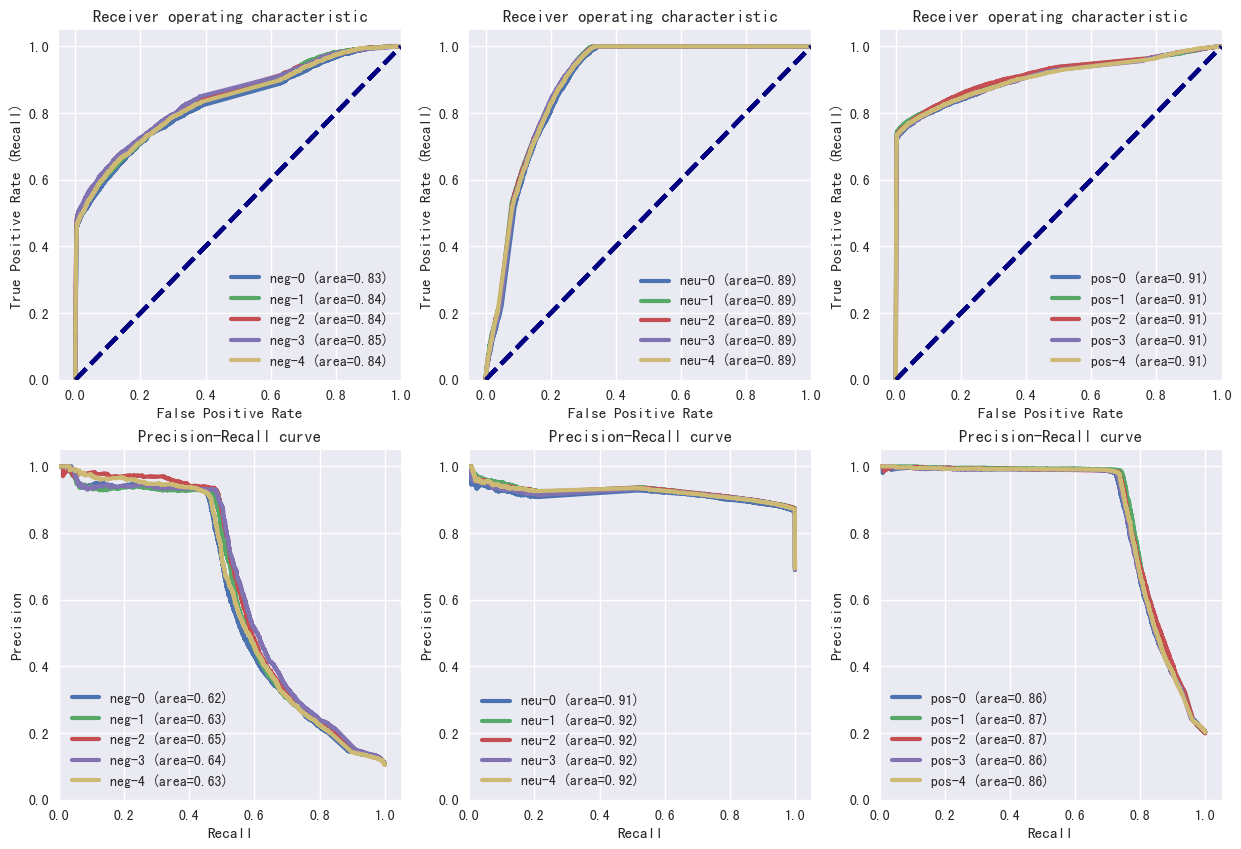

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


now training: clf_dtree
              precision    recall  f1-score   support

         neg       0.61      0.49      0.54     13423
         neu       0.88      0.94      0.91     87237
         pos       0.85      0.74      0.79     25398

    accuracy                           0.85    126058
   macro avg       0.78      0.72      0.75    126058
weighted avg       0.84      0.85      0.84    126058



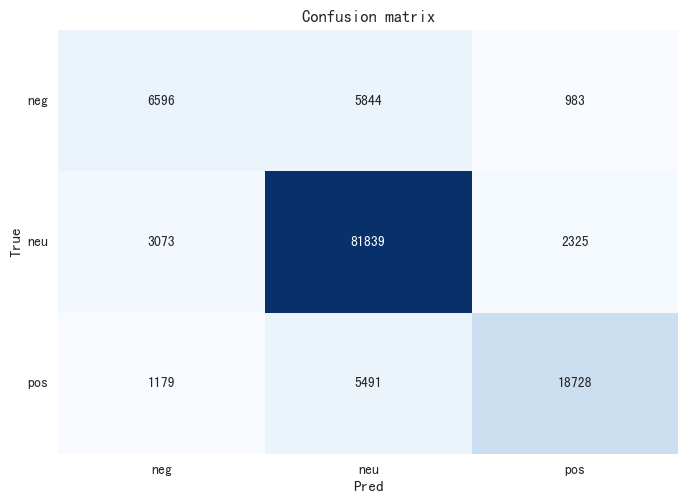

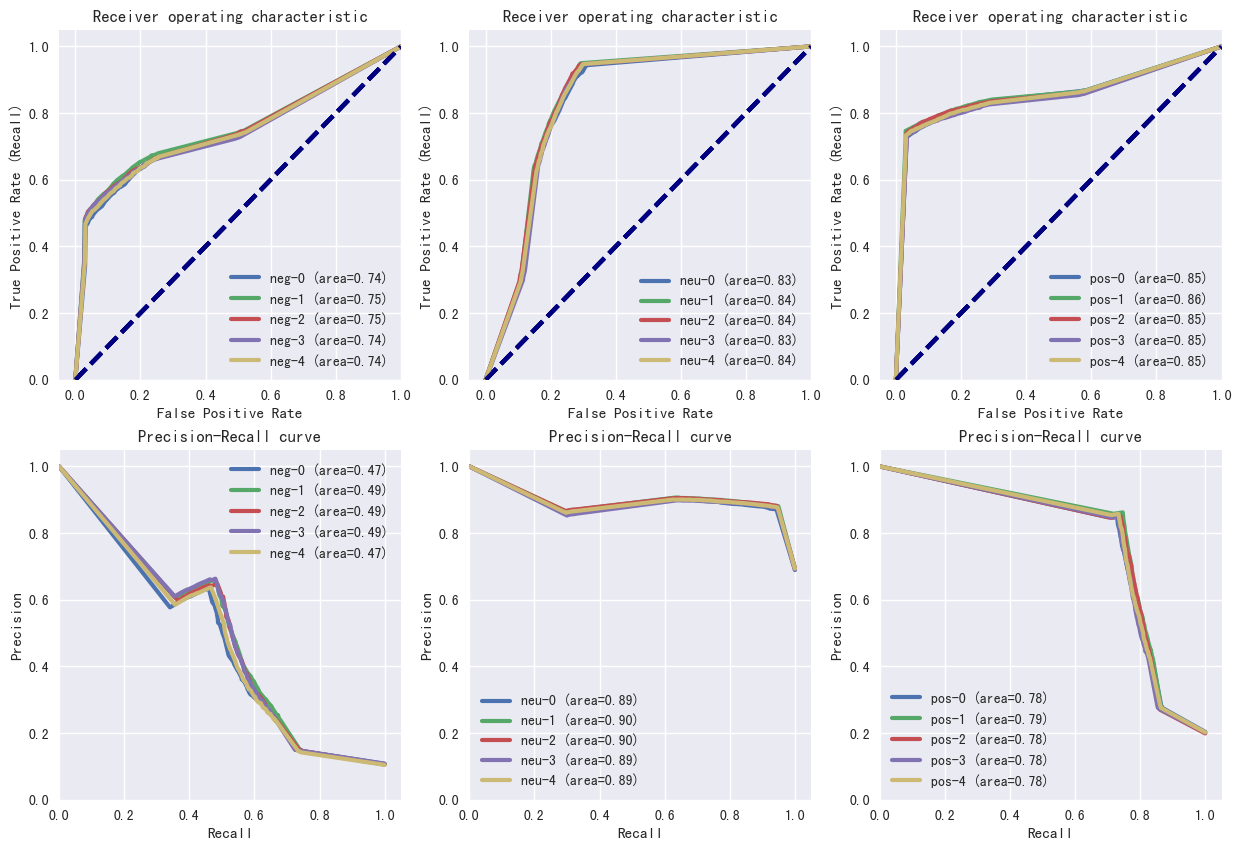

In [66]:
X = data_half["clean_txt"]
y = data_half["label"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
# model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
vectorizer = CountVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


In [67]:
result_set['clf_logistic']

{'neg': {'precision': 0.8860828987098545,
  'recall': 0.480965506965656,
  'f1-score': 0.6234970302766912,
  'support': 13423},
 'neu': {'precision': 0.872501106150195,
  'recall': 0.9945894517234659,
  'f1-score': 0.929553623561048,
  'support': 87237},
 'pos': {'precision': 0.9679221854304636,
  'recall': 0.7365934325537444,
  'f1-score': 0.8365603899297948,
  'support': 25398},
 'accuracy': 0.8879166732773802,
 'macro avg': {'precision': 0.9088353967635044,
  'recall': 0.7373827970809556,
  'f1-score': 0.796537014589178,
  'support': 126058},
 'weighted avg': {'precision': 0.8931726460214335,
  'recall': 0.8879166732773802,
  'f1-score': 0.8782277275495096,
  'support': 126058}}

In [68]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['macro avg'][best_model_metric] > max:
        max = v['macro avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_logistic
{'accuracy': 0.8879166732773802,
 'macro avg': {'f1-score': 0.796537014589178,
               'precision': 0.9088353967635044,
               'recall': 0.7373827970809556,
               'support': 126058},
 'neg': {'f1-score': 0.6234970302766912,
         'precision': 0.8860828987098545,
         'recall': 0.480965506965656,
         'support': 13423},
 'neu': {'f1-score': 0.929553623561048,
         'precision': 0.872501106150195,
         'recall': 0.9945894517234659,
         'support': 87237},
 'pos': {'f1-score': 0.8365603899297948,
         'precision': 0.9679221854304636,
         'recall': 0.7365934325537444,
         'support': 25398},
 'weighted avg': {'f1-score': 0.8782277275495096,
                  'precision': 0.8931726460214335,
                  'recall': 0.8879166732773802,
                  'support': 126058}}


In [69]:
y_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         neg       0.89      0.47      0.62      5697
         neu       0.87      1.00      0.93     37434
         pos       0.97      0.73      0.83     10895

    accuracy                           0.89     54026
   macro avg       0.91      0.73      0.79     54026
weighted avg       0.89      0.89      0.88     54026



### 5.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate 代表特徵每增加一單位（在此處會是該文章的某字詞頻 +1），y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉logistic regression + cv tokenizer 為例

In [73]:
model_set[best_model_name]

LogisticRegression()

In [74]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("Word Frequency", size=14)

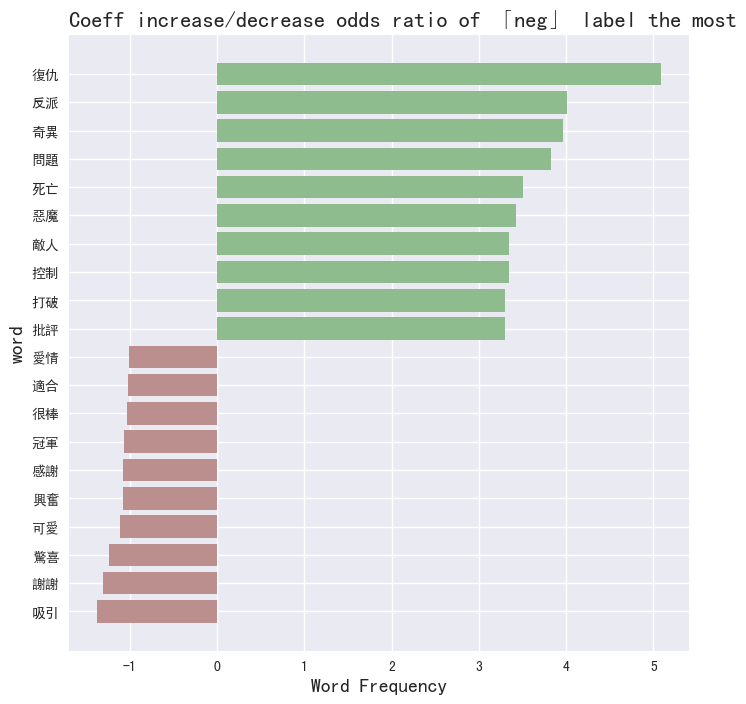

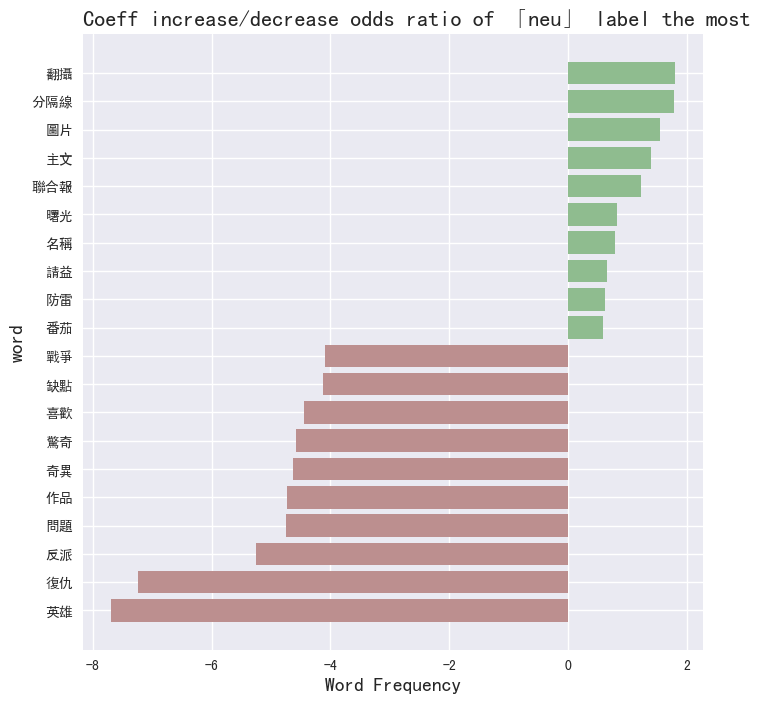

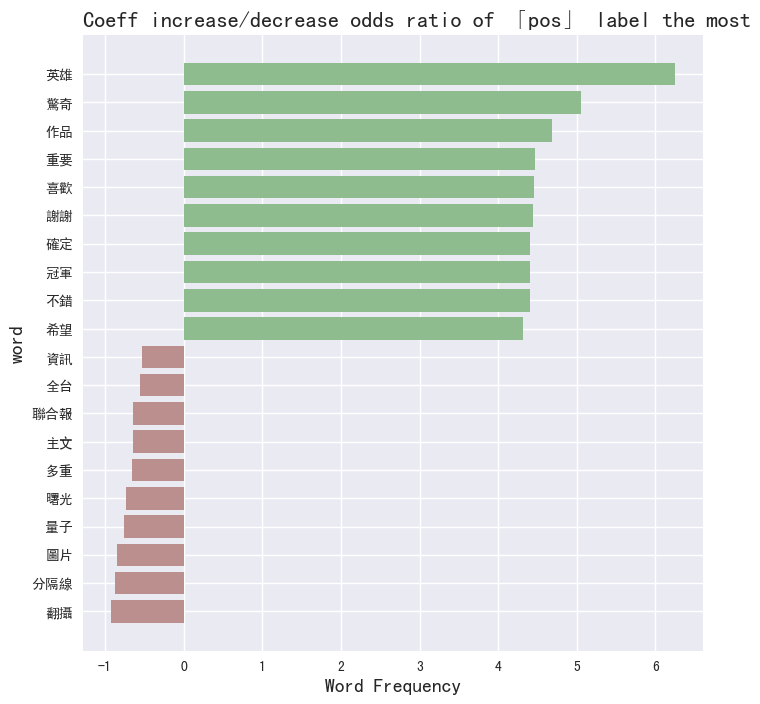

In [155]:
plot_coef(logistic_reg_model=model_set[best_model_name], feature_names=vectorizer.get_feature_names_out(), top_n=10)

## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文黨集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

In [3]:
udn = pd.read_csv("raw_data/udn.csv")  # 匯資料
udn.head(3)

,artTitle,artContent,artCatagory
0,MLB／大谷轟釀酒人已是第20隊 只剩國聯這9隊還未遭殃,大聯盟本季推出新賽制，各隊必須對戰兩聯盟29支敵隊，「大谷旋風」有機會橫掃全美，天使隊這次作...,運動
1,NBA／三分球失準宛如昔日火箭 塞爾蒂克搶七陷危機,在0勝3敗後力爭上游的塞爾蒂克，靠著懷特（Derrick White）的驚天絕殺秀硬是將戰局...,運動
2,NBA／連三戰30分助76人聽牌 安比德緊追艾佛森、張伯倫,在系列賽前4戰打完與塞爾蒂克隊戰成平手後，76人隊今天作客綠衫軍主場，安比德（Joel Em...,運動


### 前處理

In [5]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artCatagory" ]]  # 文章內容 文章連結
udn.head(3)

,content,artCatagory
0,大聯盟本季推出新賽制各隊必須對戰兩聯盟支敵隊大谷旋風有機會橫掃全美天使隊這次作客密爾瓦基就是...,運動
1,在勝敗後力爭上游的塞爾蒂克靠著懷特的驚天絕殺秀硬是將戰局拉到搶七大戰而且還是回到自家主場進行...,運動
2,在系列賽前戰打完與塞爾蒂克隊戰成平手後人隊今天作客綠衫軍主場安比德馬克西分別攻下分分以取得系...,運動


In [6]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")
jieba.load_userdict('dict/user_dict.txt')

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

user_stop = [ "這部","電影" ,"對於", "愈來愈", "就是", "什麼"]
for i in user_stop:
    stopWords.append(i)

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(str(row), cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from d:\school\社群媒體\課堂code\week12_topic_model\dict\dict.txt ...
Dumping model to file cache C:\Users\user\AppData\Local\Temp\jieba.u9f3214435cad1f341a4d17827169cb67.cache
Loading model cost 0.820 seconds.
Prefix dict has been built successfully.


,content,artCatagory,words
0,大聯盟本季推出新賽制各隊必須對戰兩聯盟支敵隊大谷旋風有機會橫掃全美天使隊這次作客密爾瓦基就是...,運動,"[大聯盟, 本季, 推出, 新賽制, 各隊, 對戰, 聯盟, 敵隊, 大谷, 旋風, 機會,..."
1,在勝敗後力爭上游的塞爾蒂克靠著懷特的驚天絕殺秀硬是將戰局拉到搶七大戰而且還是回到自家主場進行...,運動,"[勝敗, 力爭上游, 塞爾, 蒂克, 懷特, 驚天, 絕殺秀, 硬是, 戰局, 拉到, 搶七..."
2,在系列賽前戰打完與塞爾蒂克隊戰成平手後人隊今天作客綠衫軍主場安比德馬克西分別攻下分分以取得系...,運動,"[系列賽, 前戰, 打完, 塞爾, 蒂克, 戰成, 平手, 人隊, 今天, 作客, 綠衫軍,..."
3,人隊今天以敗給塞爾蒂克隊雖然還未遭到淘汰但對最不會在第二輪關門的教頭瑞佛斯來說已然是天大的壞...,運動,"[今天, 敗給, 塞爾, 蒂克, 還未, 遭到, 淘汰, 第二輪, 關門, 教頭, 瑞佛斯,..."
4,第六戰回到邁阿密尋求在自家終結系列賽的熱火靠著第四節中一波關鍵比攻勢加上強悍的防守壓制對手反...,運動,"[六戰, 回到, 邁阿密, 尋求, 終結, 系列賽, 熱火, 第四節, 一波, 關鍵, 攻勢..."


**4.1 正式處理**

In [7]:
docs = udn['words'].to_list()
docs[0]

['大聯盟',
 '本季',
 '推出',
 '新賽制',
 '各隊',
 '對戰',
 '聯盟',
 '敵隊',
 '大谷',
 '旋風',
 '機會',
 '橫掃',
 '全美',
 '天使隊',
 '作客',
 '密爾瓦基',
 '例子',
 '大谷翔平',
 '今天',
 '局上',
 '轟出',
 '陽春砲',
 '本季',
 '第轟',
 '生涯',
 '第轟',
 '出爐',
 '釀酒人',
 '成為',
 '第支',
 '開轟',
 '球隊',
 '現場',
 '球迷',
 '見證',
 '大谷',
 '怪力',
 '大谷',
 '過去',
 '球季',
 '對過',
 '釀酒人',
 '兩隊',
 '今年',
 '唯一',
 '連戰',
 '密爾瓦基',
 '米勒',
 '球場',
 '進行',
 '大谷',
 '兩戰',
 '打數',
 '安打',
 '今天',
 '支分',
 '打點',
 '幫助',
 '天使',
 '獲勝',
 '逃過',
 '連戰',
 '橫掃',
 '命運',
 '生涯',
 '對戰',
 '打擊率',
 '轉戰',
 '大聯盟',
 '大谷',
 '打者',
 '身分',
 '出賽',
 '場已',
 '球隊',
 '交手',
 '小熊隊',
 '還未',
 '碰面',
 '日將',
 '洛杉磯',
 '主場',
 '碰面',
 '機會',
 '追加',
 '開轟',
 '球隊',
 '大谷',
 '生涯',
 '紀錄',
 '交手',
 '頻繁',
 '美聯',
 '西區',
 '球隊',
 '全壘打',
 '產量',
 '最多',
 '運動家隊',
 '排名',
 '水手',
 '遊騎兵隊',
 '太空人隊',
 '不同區',
 '球隊',
 '則以',
 '白襪',
 '老虎隊',
 '最多',
 '釀酒人',
 '今天',
 '成為',
 '大谷',
 '第個',
 '受害',
 '米勒',
 '球場',
 '第座',
 '開轟',
 '大聯盟',
 '球場',
 '產量',
 '最多',
 '天使',
 '主場',
 '已有',
 '紀錄',
 '再來',
 '看看',
 '大谷',
 '對戰',
 '還未',
 '開轟',
 '球隊',
 '包括',
 '紅人',
 '國民',
 '費城人',
 '海盜',

In [8]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

Dictionary<4751 unique tokens: ['主場', '亞洲', '交手', '今天', '今年']...>


In [9]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

主場: 0
亞洲: 1
交手: 2
今天: 3
今年: 4
作客: 5
例子: 6
全壘打: 7
兩戰: 8
兩隊: 9
再來: 10
出爐: 11


將斷詞結果建構語料庫(corpus)，利用語料庫把每篇文章數字化。<br>
每篇文章、每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界-'出現2次'、'之戰'出現一次...以此類推

In [10]:
pprint(" ".join(udn['words'].iloc[600]))


('中山 醫學 大學 外系 畢業 韻蓁 畢業 公職 補習班 櫃檯 人員 負責 介紹 公職 優點 最後 說服 跳下 海當 起國 考生 幾次 報考 民政 行政 '
 '去年 鼓起 勇氣 轉了 挑戰 地政 類科 半年 考取 地特 三等 基宜 狀元 感謝 當初 願意 捨棄 大量 沉澱 成本 韻蓁 詢問 課程 卻成 介紹 '
 '課程 補習班 員工 一年 多向 無數 學生 推薦 公職 好處 心生 嚮往 離職 專心 備考 一八年 選考 民政 類科 轉考 行政 但全 失利 挫敗 '
 '一一年 高考 只差 零點 三分 錄取 韻蓁 信心 潰堤 嚴重 懷疑 適合 這條 認命 回到 補習班 工作 打算 繼續 考試 媽媽 地政 相關 公務員 '
 '韻蓁 注意到 地政 類科 競爭 人數 相對 少因 無法 忘懷 公職 目標 去年 六月 再度 選擇 離職 一場 賭注 轉考 地政 類科 身為 門外漢 只花 '
 '半年 零到 韻蓁 掌握到 快速 入門 訣竅 每天 追趕 課程 進度 拚命 每堂 看完 兩輪 確保 理解 通透 完全 吸收 強調 每一次 發現 加深 印象 '
 '更能 釐清 盲點 鞏固 觀念 熟到 出什麼 題目 腦袋 裡的 東西 直接 拿出來 時間 有限 韻蓁 動筆 申論題 只靠 大量 瀏覽 歷屆 試題 參考 '
 '擬答 一天 最多 看過 六七十題 指出 土地 經濟學 不動產 估價 這兩科 需要 數學 文組 出身 苦手 兩次 觀念 正確 歷屆 試題 掌握 考試 題型 '
 '民法 專攻 物權 土地 政策 關注 相關 新聞 定期 追蹤 幾個 地政 學者 臉書 多方 搜集 見解 擴充 思考 面向 當初 鼓起 勇氣 跨轉 地政 '
 '韻蓁 備考 期間 惶惶 不安 每天 以淚 洗面 國考 這條 最大 痛苦 上岸 不斷 鼓勵 試試 感謝 當初 勇敢 放棄 大量 沈澱 成本 跳出來 地政 '
 '告訴 還在 苦海 考生 崩潰 時就給 一小段 時間 充電 休息 滿血 回歸 努力 堅持 價值 韻蓁 去年 鼓起 勇氣 轉了 挑戰 地政 類科 半年 考取 '
 '地特 三等 基宜 狀元 記者 葉冠妤 製表 地方 特考 三等 地政 報考 資訊 記者 葉冠妤 製表 整理 包年 國中 教育 考科 完整 試題 解答 考生 '
 '注意 學測 成績 轉換 分科 測驗 級分 查詢 會考 英文 單字 片語 培養 

In [11]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(21, 1),
 (36, 1),
 (70, 1),
 (74, 1),
 (87, 1),
 (98, 3),
 (103, 1),
 (135, 2),
 (193, 1),
 (203, 1)]

In [12]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [13]:
type(corpus)

list

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [15]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=2023, # 亂數
)

**4.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
`'0.020*"經典賽" + 0.014*"中華隊" + 0.011*"今天" + 0.009*"比賽" + 0.009*"日本" + 0.007*"棒球" + 0.007*"世界" + 0.007*"投手" + 0.006*"先發" + 0.005*"球隊"'`  
-> 第二個主題的詞彙分佈，0.020: "經典賽", 0.014: "中華隊", 0.011: "今天", 0.009: "比賽"...（全部詞彙加起來會等於一）

In [16]:
ldamodel.print_topics(num_words=10)

[(0,
  '0.006*"今年" + 0.006*"會考" + 0.006*"表示" + 0.006*"行人" + 0.005*"學生" + 0.004*"教育" + 0.004*"大學" + 0.004*"學習" + 0.003*"伺服器" + 0.003*"路口"'),
 (1,
  '0.009*"會考" + 0.008*"考生" + 0.006*"今天" + 0.005*"學生" + 0.005*"國中" + 0.004*"學習" + 0.004*"大學" + 0.004*"教育" + 0.004*"成績" + 0.003*"季後賽"'),
 (2,
  '0.009*"學生" + 0.006*"表示" + 0.006*"會考" + 0.006*"台灣" + 0.006*"行人" + 0.005*"大學" + 0.005*"今天" + 0.004*"季後賽" + 0.004*"提供" + 0.004*"今年"'),
 (3,
  '0.007*"湖人" + 0.006*"季後賽" + 0.005*"今天" + 0.005*"塞爾" + 0.005*"表示" + 0.004*"蒂克" + 0.004*"熱火" + 0.004*"行人" + 0.004*"今年" + 0.004*"路口"')]

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一：兩岸新聞
+ 主題二：經典賽
+ 主題三：台股新聞
+ 主題四：台股個產業面分析

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [18]:
ldamodel.get_document_topics(corpus[0])

[(1, 0.3099729), (3, 0.6848795)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [89]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2023-05-07 19:43:08,993 : INFO : -8.690 per-word bound, 412.9 perplexity estimate based on a held-out corpus of 9800 documents with 1729558 words


-8.689541123539499

In [90]:
np.exp2(-perplexity)

412.86923896004157

In [2]:
# pmi
PMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

NameError: name 'CoherenceModel' is not defined

In [43]:
PMI_model_lda.get_coherence_per_topic()

[0.010691676424834266,
 -0.002081036551836641,
 0.04045407382319685,
 -0.018278412414447595,
 0.030944913708508336,
 0.02290030765515249,
 0.029575307297555427]

`npmi` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡以 perplexity 為指標，因為gensim套件的問題，我們將其進行轉換。<br>
這裡我們選擇主題數 4 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [33]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2023-05-06 18:12:51,397 : INFO : using symmetric alpha at 0.5
2023-05-06 18:12:51,398 : INFO : using symmetric eta at 0.5
2023-05-06 18:12:51,401 : INFO : using serial LDA version on this node
2023-05-06 18:12:51,407 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 9800 documents, updating model once every 2000 documents, evaluating perplexity every 9800 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-06 18:12:51,409 : INFO : PROGRESS: pass 0, at document #2000/9800
2023-05-06 18:12:52,708 : INFO : merging changes from 2000 documents into a model of 9800 documents
2023-05-06 18:12:52,712 : INFO : topic #0 (0.500): 0.010*"英雄" + 0.008*"隊長" + 0.008*"美國" + 0.007*"復仇" + 0.006*"角色" + 0.005*"聯盟" + 0.005*"超人" + 0.004*"鋼鐵人" + 0.004*"系列" + 0.004*"票房"
2023-05-06 18:12:52,714 : INFO : topic #1 (0.500): 0.011*"英雄" + 0.008*"美國" + 0.008*"隊長" + 0.007*"角色" + 0.005*"超人" + 0.005*"導演" + 0.004*"觀眾" + 0.004*"漫畫" + 0.004*"聯盟" + 0.004*

花費時間: 486.1541545391083 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [22]:
result = pd.DataFrame(result)
result

NameError: name 'result' is not defined

In [21]:
result.plot.line(x='topic_num', y='perplexity')

NameError: name 'result' is not defined

<Axes: xlabel='topic_num'>

2023-05-06 18:22:04,684 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-06 18:22:04,686 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-06 18:22:04,687 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-06 18:22:04,688 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-06 18:22:04,689 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-06 18:22:04,690 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-06 18:22:04,691 : WARNING : findfont: Generic family 'sans-serif' not found beca

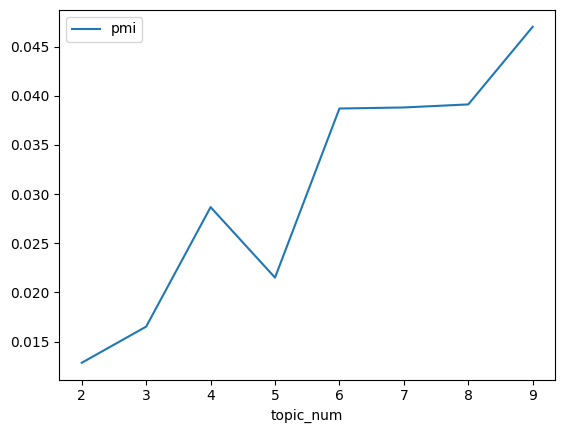

In [36]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 在 4 之後都不錯，coherence 最高則是 7

## 5. 視覺化呈現

**5.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 四個主題數，因此有四個圈圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 7 來做 LDAvis 的結果範例

In [19]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 2021,
    passes = 5 # 訓練次數
    )

In [20]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.247810 -0.020589       1        1  30.497812
1     -0.076287  0.107211       2        1  28.555650
3     -0.110549 -0.161357       3        1  22.247979
2     -0.060973  0.074736       4        1  18.698559, topic_info=     Term        Freq       Total Category  logprob  loglift
3991   行人  678.000000  678.000000  Default  30.0000  30.0000
4559   會考  918.000000  918.000000  Default  29.0000  29.0000
111   季後賽  649.000000  649.000000  Default  28.0000  28.0000
2851   學生  855.000000  855.000000  Default  27.0000  27.0000
3893   路口  426.000000  426.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
1146   指出   94.904742  316.165414   Topic4  -5.7133   0.4733
417    提供   98.852031  451.775848   Topic4  -5.6725   0.1572
4      今年  104.171358  645.791767   Topic4  -5.6201  -0.1477
3919   學校   90.329468  317.417723   Topic4  -5.7627   0.4200
1163   相關   90.336856  323.793846   Topic4  -5.7626   0.4002

[304 rows x 6 columns], token_table=      Topic      Freq Term
term                      
75        1  0.940143  三分球
75        2  0.017016  三分球
75        3  0.008508  三分球
75        4  0.034032  三分球
2153      1  0.029848   上漲
...     ...       ...  ...
3248      4  0.021735   鴻海
3311      1  0.016354   黃仁
3311      2  0.207152   黃仁
3311      3  0.763190   黃仁
3311      4  0.016354   黃仁

[972 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

lambda 的意義: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [354]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7`, `python3.8` 可正常執行

In [338]:
import guidedlda

In [339]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一共', '一壘', '世界', '並列', '中以', '中華隊', '之戰', '以色列', '休息室', '位居')

In [340]:
word2id = dictionary.token2id

In [341]:
seed_topic_list = [
    ["大谷翔平", "經典賽", "大聯盟", "先發", "張育成"],
    ["股票", "投資", "外資", "殖利率", "基金"],
    ["台積電", "半導體", "科技", "鴻海", "電動車"],
    ["中國", "兩岸", "習近平", "政府", "外交"],
    ["全球", "美國", "國際", "世界", "日本"]
]

In [342]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [343]:
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [344]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2023-05-01 19:35:27,487 : INFO : n_documents: 5985
2023-05-01 19:35:27,488 : INFO : vocab_size: 18341
2023-05-01 19:35:27,489 : INFO : n_words: 1249827
2023-05-01 19:35:27,490 : INFO : n_topics: 6
2023-05-01 19:35:27,491 : INFO : n_iter: 100
2023-05-01 19:35:27,556 : WARNING : all zero row in document-term matrix found
2023-05-01 19:35:40,971 : INFO : <0> log likelihood: -13299660
2023-05-01 19:35:41,685 : INFO : <20> log likelihood: -10181898
2023-05-01 19:35:42,316 : INFO : <40> log likelihood: -10108922
2023-05-01 19:35:42,934 : INFO : <60> log likelihood: -10082780
2023-05-01 19:35:43,546 : INFO : <80> log likelihood: -10071393
2023-05-01 19:35:44,153 : INFO : <99> log likelihood: -10062524


In [345]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 經典賽 中華隊 棒球 今天 世界 日本 投手 先發 大聯盟 安打
Topic 1: 指數 市場 投資 台股 銀行 美國 股價 投資人 上漲 億元
Topic 2: 億元 去年 營收 今年 市場 成長 公司 產品 純益 持續
Topic 3: 中國 大陸 發展 表示 國家 報導 經濟 美國 工作 香港
Topic 4: 台灣 選手 今天 賽事 運動 世界 網友 表示 今年 女子
Topic 5: 今天 比賽 高中 球隊 聯盟 球員 主場 戰績 籃板 經典賽


/home/evan19983314/.conda/envs/py37/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.127202  0.160613       1        1  24.228210
0      0.249488 -0.050370       2        1  20.776521
2     -0.252005 -0.039789       3        1  17.127880
4      0.118818  0.215447       4        1  15.176116
1     -0.216880 -0.140543       5        1  12.767808
5      0.227782 -0.145358       6        1   9.923465, topic_info=     Term         Freq        Total Category  logprob  loglift
41    經典賽  9484.000000  9484.000000  Default  30.0000  30.0000
5     中華隊  4877.000000  4877.000000  Default  29.0000  29.0000
29     棒球  4045.000000  4045.000000  Default  28.0000  28.0000
148    中國  6950.000000  6950.000000  Default  27.0000  27.0000
9820   營收  3269.000000  3269.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
2702   比分   455.443519  1670.576394   Topic6  -5.6070   1.0106
1496   賽程   408.501905  2019.329320   Topic6  -5.7158   0.7122
1120   大學   390.524266  1205.971066   Topic6  -5.7608   1.1827
3940   專欄   395.518055  1568.684461   Topic6  -5.7481   0.9325
36     球迷   396.516812  1943.483478   Topic6  -5.7455   0.7207

[445 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
4422       1  1.000320  一次會議
8123       6  1.001034   三分球
145        2  1.000600    三振
4935       1  0.941848    上海
4935       3  0.046183    上海
...      ...       ...   ...
5391       4  0.132278    高雄
5391       6  0.670326    高雄
2203       6  1.000827    魔獸
8212       6  1.000812    鵜鶘
13878      5  1.000686    點收

[832 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 5, 2, 6])

In [346]:
seed_topic_list = [
    ["大谷翔平", "經典賽", "大聯盟", "先發", "張育成"],
    ['湖人', '太陽', '西區', '灰熊', "季後賽", "助攻", '籃板', '西區', '莫蘭', '杜蘭特', '公鹿', '獨行俠', '詹姆斯', '布魯克', '防守', '勇士', "快艇", "厄文", "熱火", "金塊"],
    ["股票", "投資", "外資", "殖利率", "基金", "台積電", "半導體", "科技", "鴻海", "電動車"],
    ["中國", "兩岸", "習近平", "政府", "外交"],
    ["大陸","網友","媒體","網路"],
]

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [347]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2023-05-01 19:35:46,374 : INFO : n_documents: 5985
2023-05-01 19:35:46,375 : INFO : vocab_size: 18341
2023-05-01 19:35:46,376 : INFO : n_words: 1249827
2023-05-01 19:35:46,376 : INFO : n_topics: 6
2023-05-01 19:35:46,377 : INFO : n_iter: 100
2023-05-01 19:35:46,442 : WARNING : all zero row in document-term matrix found
2023-05-01 19:35:59,772 : INFO : <0> log likelihood: -13303534
2023-05-01 19:36:00,459 : INFO : <20> log likelihood: -10138977
2023-05-01 19:36:01,070 : INFO : <40> log likelihood: -10076344
2023-05-01 19:36:01,673 : INFO : <60> log likelihood: -10058990
2023-05-01 19:36:02,273 : INFO : <80> log likelihood: -10052959
2023-05-01 19:36:02,869 : INFO : <99> log likelihood: -10048187


In [348]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 經典賽 中華隊 棒球 今天 世界 日本 投手 先發 大聯盟 安打
Topic 1: 今天 比賽 球隊 高中 聯盟 球員 主場 籃板 戰績 勇士
Topic 2: 億元 市場 去年 營收 今年 成長 公司 投資 指數 表示
Topic 3: 中國 大陸 發展 經濟 國家 美國 表示 台灣 企業 政府
Topic 4: 公司 表示 香港 報導 網友 中國 時間 目前 認為 工作
Topic 5: 今天 台灣 選手 賽事 運動 世界 比賽 經典賽 今年 馬拉松


/home/evan19983314/.conda/envs/py37/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.232659  0.220435       1        1  27.350005
0     -0.221228 -0.007257       2        1  21.039358
3      0.210204 -0.061415       3        1  16.545372
4      0.141199 -0.194220       4        1  15.893910
5     -0.146273 -0.047855       5        1   9.831993
1     -0.216561  0.090312       6        1   9.339363, topic_info=     Term         Freq        Total Category  logprob  loglift
41    經典賽  9484.000000  9484.000000  Default  30.0000  30.0000
148    中國  6949.000000  6949.000000  Default  29.0000  29.0000
5     中華隊  4877.000000  4877.000000  Default  28.0000  28.0000
29     棒球  4045.000000  4045.000000  Default  27.0000  27.0000
56     今天  7569.000000  7569.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
2702   比分   399.487957  1670.451129   Topic6  -5.6774   0.9403
36     球迷   386.504923  1943.468684   Topic6  -5.7104   0.7558
1120   大學   368.528414  1205.784486   Topic6  -5.7581   1.1856
3940   專欄   364.533634  1568.563656   Topic6  -5.7690   0.9116
1496   賽程   356.544075  2019.168262   Topic6  -5.7911   0.6369

[430 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
357       2  0.035562    一名
357       3  0.012701    一名
357       4  0.825541    一名
357       6  0.127006    一名
4422      3  1.000502  一次會議
...     ...       ...   ...
5391      3  0.017876    高雄
5391      5  0.162673    高雄
5391      6  0.627453    高雄
2203      6  1.000890    魔獸
8212      6  1.000875    鵜鶘

[824 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 5, 6, 2])

In [349]:
# udn.loc[udn['artCatagory']=='兩岸', "content"].to_csv("tmp.csv")
udn.loc[udn['artCatagory']=='兩岸', "words"].to_csv("words.csv")
udn.loc[udn['artCatagory']=='股市', "words"].to_csv("words_stock.csv")


In [350]:
udn.loc[udn['artCatagory']=='兩岸', "words"].explode().value_counts().to_csv("words_count.csv")
udn.loc[udn['artCatagory']=='股市', "words"].explode().value_counts().to_csv("words_count_stock.csv")

## 7. 主題分佈的應用，搭配其他文章資訊

In [46]:
# 取得每條新聞的主題分佈
topics_doc = best_model.get_document_topics(corpus)

In [47]:
topics_doc[100]

[(1, 0.13217634), (2, 0.7245796), (3, 0.10225851), (5, 0.035722207)]

In [48]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.        , 0.27858537, 0.01717705, ..., 0.10678971, 0.05615531,
        0.34355301],
       [0.        , 0.23967241, 0.        , ..., 0.        , 0.51985234,
        0.23702407],
       [0.20740081, 0.        , 0.16410092, ..., 0.48717943, 0.        ,
        0.13486218],
       ...,
       [0.07043909, 0.02134021, 0.14169532, ..., 0.        , 0.60501248,
        0.16003324],
       [0.10496557, 0.        , 0.        , ..., 0.        , 0.02249433,
        0.14167304],
       [0.        , 0.        , 0.13133278, ..., 0.        , 0.55922121,
        0.30596143]])

In [49]:
udn['topic_label'] = m_theta.argmax(axis=1) + 1

In [50]:
udn['topic_label'].value_counts()

topic_label
4    3278
6    2599
7    1147
3     992
1     670
5     664
2     450
Name: count, dtype: int64

In [51]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,微雷提醒提醒你這是一篇關於鋼鐵人鋼鐵人無敵浩克雷神索爾美國隊長和復仇者聯盟的文章如果你有漏掉...,https://www.ptt.cc/bbs/movie/M.1329932440.A.CA...,movie,2012-02-22 17:34:38,"[微雷, 提醒, 提醒, 一篇, 鋼鐵人, 鋼鐵人, 無敵, 浩克, 雷神索爾, 美國, 隊...",7
1,新聞網址中國時報影視組綜合報導鋼鐵人金鋼狼武士之戰是今年最受矚目的超級英雄電影同屬漫威漫畫人...,https://www.ptt.cc/bbs/movie/M.1364375647.A.91...,movie,2013-03-27 09:08:04,"[新聞, 網址, 中國時報, 影視, 綜合, 報導, 鋼鐵人, 金鋼狼, 武士, 之戰, 今...",6
2,親愛的網友您好想要搶先看鋼鐵人嗎只要參加以下活動與外推活動訊息並且留下您的大名以及基本資料就...,https://www.ptt.cc/bbs/movie/M.1365409989.A.FD...,movie,2013-04-08 08:27:06,"[親愛的, 網友, 您好, 想要, 搶先, 鋼鐵人, 參加, 以下, 活動, 外推, 活動,...",5
3,只要在上映首日觀看鋼鐵人就有機會參加漫威首日瘋超多大獎等你拿只限首日喔快去訂票吧獎品有玩具還...,https://www.ptt.cc/bbs/movie/M.1365762576.A.84...,movie,2013-04-12 10:23:19,"[上映, 首日, 觀看, 鋼鐵人, 機會, 參加, 首日, 超多, 大獎, 首日, 訂票, ...",1
4,無雷不用防昨天衝著阿湯哥去看了遺落戰境事前一點功課也沒做只知道是類似科幻片這樣因為有長輩贈票...,https://www.ptt.cc/bbs/movie/M.1366098783.A.C2...,movie,2013-04-16 07:46:58,"[無雷, 不用, 昨天, 衝著, 阿湯哥, 遺落, 戰境, 一點, 功課, 知道, 類似, ...",4


In [52]:
udn['artDate'] = pd.to_datetime(udn['artDate'])


In [53]:
udn['artDate'].dt.date

0       2012-02-22
1       2013-03-27
2       2013-04-08
3       2013-04-12
4       2013-04-16
           ...    
9795    2023-05-03
9796    2023-05-03
9797    2023-05-03
9798    2023-05-03
9799    2023-05-03
Name: artDate, Length: 9800, dtype: object

In [54]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2012-02-22  7              1.000000
2013-03-27  6              1.000000
2013-04-08  5              1.000000
2013-04-12  1              1.000000
2013-04-16  4              1.000000
                             ...   
2023-05-02  3              0.333333
            4              0.333333
2023-05-03  4              0.733333
            6              0.133333
            3              0.133333
Name: proportion, Length: 5624, dtype: float64

In [55]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5,6,7
artDate,,,,,,,
2012-02-22,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2013-03-27,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2013-04-08,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2013-04-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-16,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [56]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)

<Axes: xlabel='artDate'>

2023-05-07 01:06:05,854 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-07 01:06:05,859 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-07 01:06:05,860 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-07 01:06:05,862 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-07 01:06:05,863 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-07 01:06:05,865 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-07 01:06:05,867 : WARNING : findfont: Generic family 'sans-serif' not found beca

Error in callback <function _draw_all_if_interactive at 0x0000019DB4F72290> (for post_execute):


KeyboardInterrupt: 

2023-05-07 01:06:29,641 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-07 01:06:29,645 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-07 01:06:29,649 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-07 01:06:29,652 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-07 01:06:29,656 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-07 01:06:29,660 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK JP
2023-05-07 01:06:29,666 : WARNING : findfont: Generic family 'sans-serif' not found beca

透過搭配文章的資訊（例如日期等），可以讓主題模型的結果做出更多的分析應用